<h1> The main purpose of project </h1>

<h3> The main goal of the project was to use machine learning models to confirm or reject hypotheses related to fetal well-being assessment. For each hypothesis, different columns of the dataset were taken to train the model. Several machine learning models were tested for performance. Variants with and without data resampling were also tested. </h3>

## Libraries import

In [1]:
from sklearn.model_selection import train_test_split
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import warnings
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm

warnings.filterwarnings('ignore')

## Data preparation

Dataset was taken from kaggle:
https://www.kaggle.com/datasets/andrewmvd/fetal-health-classification

The original dataset included 3 classes:
- Normal
- Suspect
- Pathological

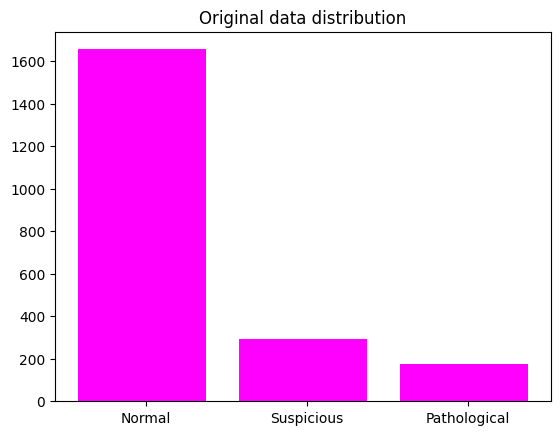

In [2]:
data = pd.read_csv("./dataset/fetal_health.csv")
data_counts = Counter(data['fetal_health'])

class_labels = ['Normal', 'Suspicious', 'Pathological']
index = [1,2,3]
bar_width = 0.05
plt.bar(data_counts.keys(), data_counts.values(), color="magenta")
plt.xticks([i + bar_width / 2 for i in index], class_labels)
plt.title("Original data distribution")
plt.show()

In this project class Suspicious and Pathological were taken as one and were marked as "Suspicious".

In [3]:
data['fetal_health'] = [1 if item == 1 else 0 for item in data['fetal_health']]

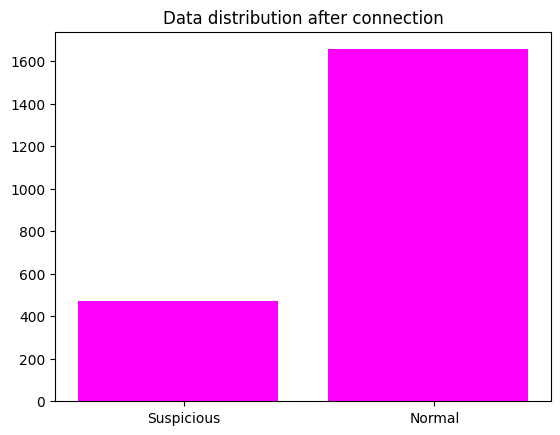

In [4]:
class_labels = ['Suspicious', 'Normal']
data_counts = Counter(data['fetal_health'])
index = [0,1]
bar_width = 0.05
plt.bar(data_counts.keys(), data_counts.values(), color="magenta")
plt.xticks([i + bar_width / 2 for i in index], class_labels)
plt.title("Data distribution after connection")
plt.show()

Dataset was divided into train and test dataset in proportion 80:20.

In [5]:
X = data.iloc[:, :-1]
y = data.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

In [6]:
train_data = train_data.rename(columns={'baseline value': 'baseline',
                                        'accelerations': 'accelerations',
                                        'uterine_contractions': 'uterine_contr',
                                        'light_deccelerations': 'deccelerations',
                                        'abnormal_short_term_variability': 'abn_short_term_var',
                                        'mean_value_of_short_term_variability': 'short_term_var_mean',
                                        'percentage_of_time_with_abnormal_long_term_variability': '%_abn_long_term_var',
                                        'mean_value_of_long_term_variability': 'long_term_var_mean',
                                        'histogram_width': 'hist_width',
                                        'histogram_min': 'hist_min',
                                        'histogram_max': 'hist_max',
                                        'histogram_number_of_peaks': 'hist_peaks_num',
                                        'histogram_number_of_zeroes': 'hist_zeroes_num',
                                        'histogram_mode': 'hist_mode',
                                        'histogram_mean': 'hist_mean',
                                        'histogram_median': 'hist_median',
                                        'histogram_variance': 'hist_variance',
                                        'histogram_tendency': 'hist_tendency',
                                        'fetal_health': 'class'})

test_data = test_data.rename(columns={'baseline value': 'baseline',
                                      'accelerations': 'accelerations',
                                      'uterine_contractions': 'uterine_contr',
                                      'light_deccelerations': 'deccelerations',
                                      'abnormal_short_term_variability': 'abn_short_term_var',
                                      'mean_value_of_short_term_variability': 'short_term_var_mean',
                                      'percentage_of_time_with_abnormal_long_term_variability': '%_abn_long_term_var',
                                      'mean_value_of_long_term_variability': 'long_term_var_mean',
                                      'histogram_width': 'hist_width',
                                      'histogram_min': 'hist_min',
                                      'histogram_max': 'hist_max',
                                      'histogram_number_of_peaks': 'hist_peaks_num',
                                      'histogram_number_of_zeroes': 'hist_zeroes_num',
                                      'histogram_mode': 'hist_mode',
                                      'histogram_mean': 'hist_mean',
                                      'histogram_median': 'hist_median',
                                      'histogram_variance': 'hist_variance',
                                      'histogram_tendency': 'hist_tendency',
                                      'fetal_health': 'class'})


In [7]:
X_train = train_data.drop('class', axis=1)
X_test= test_data.drop('class', axis=1)
y_train = train_data['class']
y_test = test_data['class']

y_train_counter = Counter(y_train)
y_test_counter = Counter(y_test)

print("TRAIN DATASET \nNormal: {}\nSuspicious: {}\nNumber of features: {}\n".format(y_train_counter[1], y_train_counter[0], X_train.shape[1]))
print("TEST DATASET \nNormal: {}\nSuspicious: {}\nNumber of features: {}\n".format(y_test_counter[1], y_test_counter[0], X_test.shape[1]))
print("FEATURES: \n", list(X_train.columns))

TRAIN DATASET 
Normal: 1322
Suspicious: 378
Number of features: 21

TEST DATASET 
Normal: 333
Suspicious: 93
Number of features: 21

FEATURES: 
 ['baseline', 'accelerations', 'fetal_movement', 'uterine_contr', 'light_decelerations', 'severe_decelerations', 'prolongued_decelerations', 'abn_short_term_var', 'short_term_var_mean', '%_abn_long_term_var', 'long_term_var_mean', 'hist_width', 'hist_min', 'hist_max', 'hist_peaks_num', 'hist_zeroes_num', 'hist_mode', 'hist_mean', 'hist_median', 'hist_variance', 'hist_tendency']


## Data division for hypothesis testing purposes

Each hypothesis required different inputs to assess its validity

In [8]:
# Hypothesis 1 - heart rate variability
variability_features_train = train_data[['accelerations', 'light_decelerations', 'abn_short_term_var', 'short_term_var_mean','%_abn_long_term_var', 'long_term_var_mean']]
variability_features_test = test_data[['accelerations', 'light_decelerations', 'abn_short_term_var', 'short_term_var_mean','%_abn_long_term_var', 'long_term_var_mean']]

scaler = MinMaxScaler()
numeric_columns = variability_features_train.select_dtypes(include=['float64', 'int64']).columns
variability_features_train[numeric_columns] = scaler.fit_transform(variability_features_train[numeric_columns])
variability_features_test[numeric_columns] = scaler.transform(variability_features_test[numeric_columns])


# Hypothesis 2 - histogram parameters
histogram_features_train = train_data[['hist_width', 'hist_min', 'hist_max', 'hist_peaks_num', 'hist_zeroes_num', 'hist_mode', 'hist_mean', 'hist_median', 'hist_variance', 'hist_tendency']]
histogram_features_test = test_data[['hist_width', 'hist_min', 'hist_max', 'hist_peaks_num', 'hist_zeroes_num', 'hist_mode', 'hist_mean', 'hist_median', 'hist_variance', 'hist_tendency']]

scaler = MinMaxScaler()
numeric_columns = histogram_features_train.select_dtypes(include=['float64', 'int64']).columns
histogram_features_train[numeric_columns] = scaler.fit_transform(histogram_features_train[numeric_columns])
histogram_features_test[numeric_columns] = scaler.transform(histogram_features_test[numeric_columns])

# Hypothesis 3 - the number of fetal heartbeats
baseline_features_train = train_data[['baseline']]
baseline_features_test = test_data[['baseline']]

scaler = MinMaxScaler()
numeric_columns = baseline_features_train.select_dtypes(include=['float64', 'int64']).columns
baseline_features_train[numeric_columns] = scaler.fit_transform(baseline_features_train[numeric_columns])
baseline_features_test[numeric_columns] = scaler.transform(baseline_features_test[numeric_columns])

# Hypothesis 4 - uterine contractions
uterine_contractions_train = train_data[['uterine_contr']]
uterine_contractions_test = test_data[['uterine_contr']]

scaler = MinMaxScaler()
numeric_columns = uterine_contractions_train.select_dtypes(include=['float64', 'int64']).columns
uterine_contractions_train[numeric_columns] = scaler.fit_transform(uterine_contractions_train[numeric_columns])
uterine_contractions_test[numeric_columns] = scaler.transform(uterine_contractions_test[numeric_columns])


print("FEATURES: ")
print("Histogram features: ", len(histogram_features_train.columns))
print("Variability features: ", len(variability_features_train.columns))
print("Baseline features: ", len(baseline_features_train.columns))
print("Uterine features: ", len(uterine_contractions_train.columns))


FEATURES: 
Histogram features:  10
Variability features:  6
Baseline features:  1
Uterine features:  1


## Hypotheses

In [9]:
def resample (resampling_method, X_train, y_train):
  if resampling_method == "undersampling":
      under_sampler= RandomUnderSampler(sampling_strategy='auto')
      X_train_resampled, y_train_resampled = under_sampler.fit_resample(X_train, y_train)
  if resampling_method == "oversampling":
      over_sampler= RandomOverSampler(sampling_strategy='auto')
      X_train_resampled, y_train_resampled = over_sampler.fit_resample(X_train, y_train)
  return (X_train_resampled, y_train_resampled)

In [10]:
classifiers = [RandomForestClassifier(), LogisticRegression(), KNeighborsClassifier(), svm.SVC(), BaggingClassifier(), AdaBoostClassifier()]
results_dataframe = pd.DataFrame()

#### Hypothesis 1 - Features related to heart rate variability are important factors in assessing fetal well-being

Without resampling

In [11]:
accuracies = []
for classifier in classifiers:
  print(classifier)
  classifier.fit(variability_features_train, y_train)
  y_predicted = classifier.predict(variability_features_test)
  accuracy = accuracy_score(y_test, y_predicted)
  accuracies.append(accuracy)
  print(accuracy)
  print(classification_report(y_test, y_predicted, zero_division=0))
  print(confusion_matrix(y_test, y_predicted), "\n\n")
results_dataframe = results_dataframe.append(pd.Series(["hypothesis 1","without"]+accuracies), ignore_index=True)

RandomForestClassifier()


0.9483568075117371
              precision    recall  f1-score   support

           0       0.93      0.83      0.87        93
           1       0.95      0.98      0.97       333

    accuracy                           0.95       426
   macro avg       0.94      0.90      0.92       426
weighted avg       0.95      0.95      0.95       426

[[ 77  16]
 [  6 327]] 


LogisticRegression()
0.8685446009389671
              precision    recall  f1-score   support

           0       0.75      0.60      0.67        93
           1       0.89      0.94      0.92       333

    accuracy                           0.87       426
   macro avg       0.82      0.77      0.79       426
weighted avg       0.86      0.87      0.86       426

[[ 56  37]
 [ 19 314]] 


KNeighborsClassifier()
0.9178403755868545
              precision    recall  f1-score   support

           0       0.84      0.77      0.80        93
           1       0.94      0.96      0.95       333

    accuracy                 

With oversampling

In [12]:
accuracies = []
for classifier in classifiers:
  print(classifier)
  X_train_resampled, y_train_resampled = resample("oversampling", variability_features_train, y_train)
  print(Counter(y_train_resampled))
  classifier.fit(X_train_resampled, y_train_resampled)
  y_predicted = classifier.predict(variability_features_test)
  accuracy = accuracy_score(y_test, y_predicted)
  accuracies.append(accuracy)
  print(accuracy)
  print(classification_report(y_test, y_predicted, zero_division=0))
  print(confusion_matrix(y_test, y_predicted), "\n\n")
results_dataframe = results_dataframe.append(pd.Series(["hypothesis 1","oversampling"]+accuracies), ignore_index=True)

RandomForestClassifier()
Counter({1: 1322, 0: 1322})
0.9436619718309859
              precision    recall  f1-score   support

           0       0.88      0.86      0.87        93
           1       0.96      0.97      0.96       333

    accuracy                           0.94       426
   macro avg       0.92      0.91      0.92       426
weighted avg       0.94      0.94      0.94       426

[[ 80  13]
 [ 11 322]] 


LogisticRegression()
Counter({1: 1322, 0: 1322})
0.8028169014084507
              precision    recall  f1-score   support

           0       0.53      0.85      0.65        93
           1       0.95      0.79      0.86       333

    accuracy                           0.80       426
   macro avg       0.74      0.82      0.76       426
weighted avg       0.86      0.80      0.82       426

[[ 79  14]
 [ 70 263]] 


KNeighborsClassifier()
Counter({1: 1322, 0: 1322})
0.8802816901408451
              precision    recall  f1-score   support

           0       0.67      

With undersampling

In [13]:
accuracies = []
for classifier in classifiers:
  print(classifier)
  X_train_resampled, y_train_resampled = resample("undersampling", variability_features_train, y_train)
  print(Counter(y_train_resampled))
  classifier.fit(X_train_resampled, y_train_resampled)
  y_predicted = classifier.predict(variability_features_test)
  accuracy = accuracy_score(y_test, y_predicted)
  accuracies.append(accuracy)
  print(accuracy)
  print(classification_report(y_test, y_predicted, zero_division=0))
  print(confusion_matrix(y_test, y_predicted), "\n\n")
results_dataframe = results_dataframe.append(pd.Series(["hypothesis 1","undersampling"]+accuracies), ignore_index=True)

RandomForestClassifier()
Counter({0: 378, 1: 378})
0.8568075117370892
              precision    recall  f1-score   support

           0       0.62      0.89      0.73        93
           1       0.97      0.85      0.90       333

    accuracy                           0.86       426
   macro avg       0.79      0.87      0.82       426
weighted avg       0.89      0.86      0.87       426

[[ 83  10]
 [ 51 282]] 


LogisticRegression()
Counter({0: 378, 1: 378})
0.795774647887324
              precision    recall  f1-score   support

           0       0.52      0.85      0.64        93
           1       0.95      0.78      0.86       333

    accuracy                           0.80       426
   macro avg       0.73      0.82      0.75       426
weighted avg       0.86      0.80      0.81       426

[[ 79  14]
 [ 73 260]] 


KNeighborsClassifier()
Counter({0: 378, 1: 378})
0.8497652582159625
              precision    recall  f1-score   support

           0       0.61      0.88   

#### Hypothesis 2 - FHR histogram parameters allow classification of fetal well-being

Without resampling

In [14]:
accuracies = []
for classifier in classifiers:
  print(classifier)
  classifier.fit(histogram_features_train, y_train)
  y_predicted = classifier.predict(histogram_features_test)
  accuracy = accuracy_score(y_test, y_predicted)
  accuracies.append(accuracy)
  print(accuracy)
  print(classification_report(y_test, y_predicted, zero_division=0))
  print(confusion_matrix(y_test, y_predicted), "\n\n")
results_dataframe = results_dataframe.append(pd.Series(["hypothesis 2","without"]+accuracies), ignore_index=True)

RandomForestClassifier()
0.8826291079812206
              precision    recall  f1-score   support

           0       0.77      0.66      0.71        93
           1       0.91      0.95      0.93       333

    accuracy                           0.88       426
   macro avg       0.84      0.80      0.82       426
weighted avg       0.88      0.88      0.88       426

[[ 61  32]
 [ 18 315]] 


LogisticRegression()
0.7887323943661971
              precision    recall  f1-score   support

           0       1.00      0.03      0.06        93
           1       0.79      1.00      0.88       333

    accuracy                           0.79       426
   macro avg       0.89      0.52      0.47       426
weighted avg       0.83      0.79      0.70       426

[[  3  90]
 [  0 333]] 


KNeighborsClassifier()
0.8544600938967136
              precision    recall  f1-score   support

           0       0.70      0.59      0.64        93
           1       0.89      0.93      0.91       333

    

With oversampling

In [15]:
accuracies = []
for classifier in classifiers:
  print(classifier)
  X_train_resampled, y_train_resampled = resample("oversampling", histogram_features_train, y_train)
  print(Counter(y_train_resampled))
  classifier.fit(X_train_resampled, y_train_resampled)
  y_predicted = classifier.predict(histogram_features_test)
  accuracy = accuracy_score(y_test, y_predicted)
  accuracies.append(accuracy)
  print(accuracy)
  print(classification_report(y_test, y_predicted, zero_division=0))
  print(confusion_matrix(y_test, y_predicted), "\n\n")
results_dataframe = results_dataframe.append(pd.Series(["hypothesis 2","oversampling"]+accuracies), ignore_index=True)

RandomForestClassifier()
Counter({1: 1322, 0: 1322})
0.8943661971830986
              precision    recall  f1-score   support

           0       0.76      0.75      0.76        93
           1       0.93      0.93      0.93       333

    accuracy                           0.89       426
   macro avg       0.85      0.84      0.84       426
weighted avg       0.89      0.89      0.89       426

[[ 70  23]
 [ 22 311]] 


LogisticRegression()
Counter({1: 1322, 0: 1322})
0.6267605633802817
              precision    recall  f1-score   support

           0       0.34      0.75      0.47        93
           1       0.90      0.59      0.71       333

    accuracy                           0.63       426
   macro avg       0.62      0.67      0.59       426
weighted avg       0.77      0.63      0.66       426

[[ 70  23]
 [136 197]] 


KNeighborsClassifier()
Counter({1: 1322, 0: 1322})
0.8051643192488263
              precision    recall  f1-score   support

           0       0.54      

With undersampling

In [16]:
accuracies = []
for classifier in classifiers:
  print(classifier)
  X_train_resampled, y_train_resampled = resample("undersampling", histogram_features_train, y_train)
  print(Counter(y_train_resampled))
  classifier.fit(X_train_resampled, y_train_resampled)
  y_predicted = classifier.predict(histogram_features_test)
  accuracy = accuracy_score(y_test, y_predicted)
  accuracies.append(accuracy)
  print(accuracy)
  print(classification_report(y_test, y_predicted, zero_division=0))
  print(confusion_matrix(y_test, y_predicted), "\n\n")
results_dataframe = results_dataframe.append(pd.Series(["hypothesis 2","undersampling"]+accuracies), ignore_index=True)

RandomForestClassifier()
Counter({0: 378, 1: 378})
0.8356807511737089
              precision    recall  f1-score   support

           0       0.58      0.86      0.70        93
           1       0.96      0.83      0.89       333

    accuracy                           0.84       426
   macro avg       0.77      0.84      0.79       426
weighted avg       0.87      0.84      0.85       426

[[ 80  13]
 [ 57 276]] 


LogisticRegression()
Counter({0: 378, 1: 378})
0.6220657276995305
              precision    recall  f1-score   support

           0       0.34      0.77      0.47        93
           1       0.90      0.58      0.71       333

    accuracy                           0.62       426
   macro avg       0.62      0.68      0.59       426
weighted avg       0.78      0.62      0.65       426

[[ 72  21]
 [140 193]] 


KNeighborsClassifier()
Counter({0: 378, 1: 378})
0.755868544600939
              precision    recall  f1-score   support

           0       0.46      0.77   

#### Hypothesis 3 - The number of fetal heartbeats per minute is an insufficient factor to assess fetal well-being

Without resampling

In [17]:
accuracies = []
for classifier in classifiers:
  print(classifier)
  classifier.fit(baseline_features_train , y_train)
  y_predicted = classifier.predict(baseline_features_test)
  accuracy = accuracy_score(y_test, y_predicted)
  accuracies.append(accuracy)
  print(accuracy)
  print(classification_report(y_test, y_predicted, zero_division=0))
  print(confusion_matrix(y_test, y_predicted), "\n\n")
results_dataframe = results_dataframe.append(pd.Series(["hypothesis 3","without"]+accuracies), ignore_index=True)

RandomForestClassifier()
0.7981220657276995
              precision    recall  f1-score   support

           0       0.73      0.12      0.20        93
           1       0.80      0.99      0.88       333

    accuracy                           0.80       426
   macro avg       0.77      0.55      0.54       426
weighted avg       0.79      0.80      0.74       426

[[ 11  82]
 [  4 329]] 


LogisticRegression()
0.7723004694835681
              precision    recall  f1-score   support

           0       0.25      0.02      0.04        93
           1       0.78      0.98      0.87       333

    accuracy                           0.77       426
   macro avg       0.52      0.50      0.46       426
weighted avg       0.67      0.77      0.69       426

[[  2  91]
 [  6 327]] 


KNeighborsClassifier()
0.7723004694835681
              precision    recall  f1-score   support

           0       0.46      0.25      0.32        93
           1       0.81      0.92      0.86       333

    

With oversampling

In [18]:
accuracies = []
for classifier in classifiers:
  print(classifier)
  X_train_resampled, y_train_resampled = resample("oversampling", baseline_features_train , y_train)
  classifier.fit(X_train_resampled, y_train_resampled)
  y_predicted = classifier.predict(baseline_features_test)
  accuracy = accuracy_score(y_test, y_predicted)
  accuracies.append(accuracy)
  print(accuracy)
  print(classification_report(y_test, y_predicted, zero_division=0))
  print(confusion_matrix(y_test, y_predicted), "\n\n")
results_dataframe = results_dataframe.append(pd.Series(["hypothesis 3","oversampling"]+accuracies), ignore_index=True)

RandomForestClassifier()
0.5774647887323944
              precision    recall  f1-score   support

           0       0.30      0.73      0.43        93
           1       0.88      0.53      0.66       333

    accuracy                           0.58       426
   macro avg       0.59      0.63      0.55       426
weighted avg       0.75      0.58      0.61       426

[[ 68  25]
 [155 178]] 


LogisticRegression()
0.57981220657277
              precision    recall  f1-score   support

           0       0.28      0.61      0.39        93
           1       0.84      0.57      0.68       333

    accuracy                           0.58       426
   macro avg       0.56      0.59      0.53       426
weighted avg       0.72      0.58      0.62       426

[[ 57  36]
 [143 190]] 


KNeighborsClassifier()
0.7582159624413145
              precision    recall  f1-score   support

           0       0.42      0.28      0.34        93
           1       0.82      0.89      0.85       333

    ac

With undersampling

In [19]:
accuracies = []
for classifier in classifiers:
  print(classifier)
  X_train_resampled, y_train_resampled = resample("undersampling", baseline_features_train , y_train)
  classifier.fit(X_train_resampled, y_train_resampled)
  y_predicted = classifier.predict(baseline_features_test)
  accuracy = accuracy_score(y_test, y_predicted)
  accuracies.append(accuracy)
  print(accuracy)
  print(classification_report(y_test, y_predicted, zero_division=0))
  print(confusion_matrix(y_test, y_predicted), "\n\n")
results_dataframe = results_dataframe.append(pd.Series(["hypothesis 3","undersampling"]+accuracies), ignore_index=True)

RandomForestClassifier()


0.6056338028169014
              precision    recall  f1-score   support

           0       0.31      0.65      0.42        93
           1       0.86      0.59      0.70       333

    accuracy                           0.61       426
   macro avg       0.58      0.62      0.56       426
weighted avg       0.74      0.61      0.64       426

[[ 60  33]
 [135 198]] 


LogisticRegression()
0.57981220657277
              precision    recall  f1-score   support

           0       0.28      0.61      0.39        93
           1       0.84      0.57      0.68       333

    accuracy                           0.58       426
   macro avg       0.56      0.59      0.53       426
weighted avg       0.72      0.58      0.62       426

[[ 57  36]
 [143 190]] 


KNeighborsClassifier()
0.4061032863849765
              precision    recall  f1-score   support

           0       0.26      0.91      0.40        93
           1       0.92      0.26      0.41       333

    accuracy                   

#### Hypothesis 4 - As the value of uterine contractions increases, a decrease in fetal well-being can be observed

Without resampling

In [20]:
accuracies = []
for classifier in classifiers:
  print(classifier)
  classifier.fit(uterine_contractions_train , y_train)
  y_predicted = classifier.predict(uterine_contractions_test)
  accuracy = accuracy_score(y_test, y_predicted)
  accuracies.append(accuracy)
  print(accuracy)
  print(classification_report(y_test, y_predicted, zero_division=0))
  print(confusion_matrix(y_test, y_predicted), "\n\n")
results_dataframe = results_dataframe.append(pd.Series(["hypothesis 4","without"]+accuracies), ignore_index=True)

RandomForestClassifier()
0.8004694835680751
              precision    recall  f1-score   support

           0       0.55      0.44      0.49        93
           1       0.85      0.90      0.88       333

    accuracy                           0.80       426
   macro avg       0.70      0.67      0.68       426
weighted avg       0.79      0.80      0.79       426

[[ 41  52]
 [ 33 300]] 


LogisticRegression()
0.7816901408450704
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        93
           1       0.78      1.00      0.88       333

    accuracy                           0.78       426
   macro avg       0.39      0.50      0.44       426
weighted avg       0.61      0.78      0.69       426

[[  0  93]
 [  0 333]] 


KNeighborsClassifier()
0.8028169014084507
              precision    recall  f1-score   support

           0       0.56      0.44      0.49        93
           1       0.85      0.90      0.88       333

    

With oversampling

In [21]:
accuracies = []
for classifier in classifiers:
  print(classifier)
  X_train_resampled, y_train_resampled = resample("oversampling", uterine_contractions_train , y_train)
  classifier.fit(X_train_resampled, y_train_resampled)
  y_predicted = classifier.predict(uterine_contractions_test)
  accuracy = accuracy_score(y_test, y_predicted)
  accuracies.append(accuracy)
  print(accuracy)
  print(classification_report(y_test, y_predicted, zero_division=0))
  print(confusion_matrix(y_test, y_predicted), "\n\n")
results_dataframe = results_dataframe.append(pd.Series(["hypothesis 4","oversampling"]+accuracies), ignore_index=True)

RandomForestClassifier()


0.647887323943662
              precision    recall  f1-score   support

           0       0.34      0.67      0.45        93
           1       0.87      0.64      0.74       333

    accuracy                           0.65       426
   macro avg       0.61      0.65      0.60       426
weighted avg       0.76      0.65      0.68       426

[[ 62  31]
 [119 214]] 


LogisticRegression()
0.6525821596244131
              precision    recall  f1-score   support

           0       0.34      0.66      0.45        93
           1       0.87      0.65      0.75       333

    accuracy                           0.65       426
   macro avg       0.61      0.65      0.60       426
weighted avg       0.76      0.65      0.68       426

[[ 61  32]
 [116 217]] 


KNeighborsClassifier()
0.6971830985915493
              precision    recall  f1-score   support

           0       0.15      0.09      0.11        93
           1       0.77      0.87      0.82       333

    accuracy                  

With undersampling

In [22]:
accuracies = []
for classifier in classifiers:
  print(classifier)
  X_train_resampled, y_train_resampled = resample("undersampling", uterine_contractions_train , y_train)
  classifier.fit(X_train_resampled, y_train_resampled)
  y_predicted = classifier.predict(uterine_contractions_test)
  accuracy = accuracy_score(y_test, y_predicted)
  accuracies.append(accuracy)
  print(accuracy)
  print(classification_report(y_test, y_predicted, zero_division=0))
  print(confusion_matrix(y_test, y_predicted), "\n\n")
results_dataframe = results_dataframe.append(pd.Series(["hypothesis 4","undersampling"]+accuracies), ignore_index=True)

RandomForestClassifier()
0.7206572769953051
              precision    recall  f1-score   support

           0       0.40      0.59      0.48        93
           1       0.87      0.76      0.81       333

    accuracy                           0.72       426
   macro avg       0.64      0.67      0.64       426
weighted avg       0.77      0.72      0.74       426

[[ 55  38]
 [ 81 252]] 


LogisticRegression()
0.6525821596244131
              precision    recall  f1-score   support

           0       0.34      0.66      0.45        93
           1       0.87      0.65      0.75       333

    accuracy                           0.65       426
   macro avg       0.61      0.65      0.60       426
weighted avg       0.76      0.65      0.68       426

[[ 61  32]
 [116 217]] 


KNeighborsClassifier()
0.23708920187793428
              precision    recall  f1-score   support

           0       0.22      0.99      0.36        93
           1       0.90      0.03      0.05       333

   

#### Summary table of all results (accuracy)

In [23]:
keys = [x for x in range(0,8)]
values = ["hypothesis","resampling"] +[str(classifier).split("()")[0] for classifier in classifiers]
dataframe_columns = {keys[i]: values[i] for i in range(len(keys))}
results_dataframe = results_dataframe.rename(dataframe_columns, axis=1)
results_dataframe

,hypothesis,resampling,RandomForestClassifier,LogisticRegression,KNeighborsClassifier,SVC,BaggingClassifier,AdaBoostClassifier
0,hypothesis 1,without,0.948357,0.868545,0.917840,0.887324,0.927230,0.903756
1,hypothesis 1,oversampling,0.943662,0.802817,0.880282,0.809859,0.915493,0.868545
2,hypothesis 1,undersampling,0.856808,0.795775,0.849765,0.786385,0.849765,0.861502
3,hypothesis 2,without,0.882629,0.788732,0.854460,0.859155,0.880282,0.859155
4,hypothesis 2,oversampling,0.894366,0.626761,0.805164,0.828638,0.870892,0.816901
5,hypothesis 2,undersampling,0.835681,0.622066,0.755869,0.793427,0.807512,0.802817
6,hypothesis 3,without,0.798122,0.772300,0.772300,0.805164,0.802817,0.798122
7,hypothesis 3,oversampling,0.577465,0.579812,0.758216,0.617371,0.619718,0.600939
8,hypothesis 3,undersampling,0.605634,0.579812,0.406103,0.640845,0.584507,0.631455
9,hypothesis 4,without,0.800469,0.781690,0.802817,0.781690,0.800469,0.800469


In [24]:
def get_labels_and_values(results_dataframe):
  df_values = []
  for index, row in results_dataframe.iterrows():
          df_values.append(row.values[2:])
  return df_values

In [25]:
labels_values = get_labels_and_values(results_dataframe)

hip1=labels_values[0:3]
hip2=labels_values[3:6]
hip3=labels_values[6:9]
hip4=labels_values[9:12]


In [26]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter

def create_plot(data, title):
    x_values = np.repeat(['No resampling', 'Undersampled', 'Oversampled'], 6)  # X-axis values repeated for each data point
    markers = ['o', 'o', 'o']  # Marker styles for each list
    methods = ['RandomForestClassifier', 'LogisticRegression', 'KNeighborsClassifier', 'SVC', 'BaggingClassifier', 'AdaBoostClassifier']
    colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown']

    for i, values in enumerate(data):
        x = x_values[i * 6: (i + 1) * 6]  # Assign X-axis values to each data point
        for j in range(len(x)):
            plt.scatter(x[j], values[j], marker=markers[i], c=colors[j], label=methods[j])

    plt.xlabel('Sampling type', fontsize=13)
    plt.ylabel('Accuracy', fontsize=13)
    plt.title(f"{title}")
    plt.legend(methods, loc='upper right', bbox_to_anchor=(1.5, 1))
    plt.grid()
    # Format y-axis tick labels as percentages
    formatter = FuncFormatter(lambda y, _: '{:.1%}'.format(y))
    plt.gca().yaxis.set_major_formatter(formatter)

    plt.show()


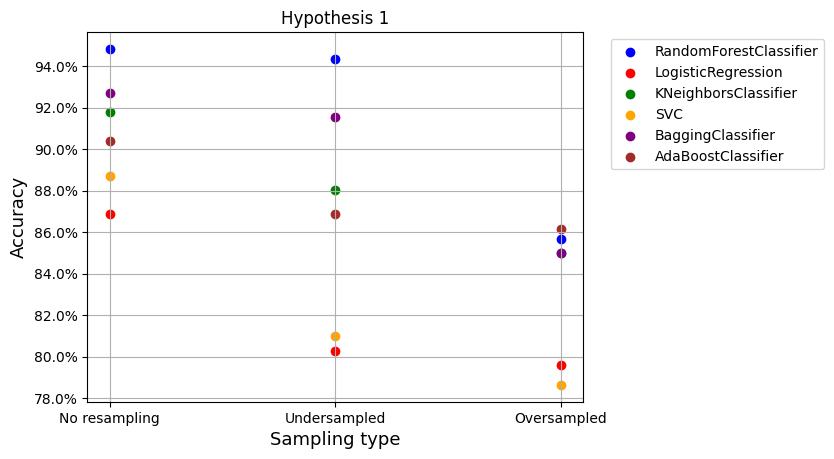

In [27]:
# Hypothesis 1
create_plot(hip1, "Hypothesis 1")

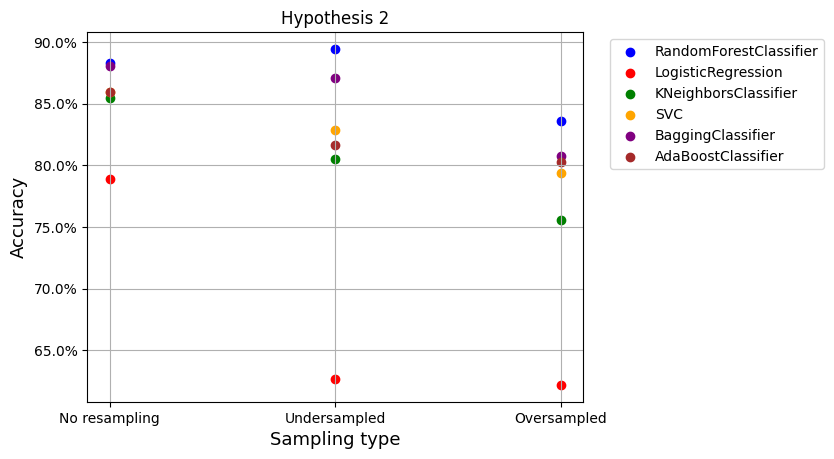

In [28]:
# Hypothesis 2
create_plot(hip2, "Hypothesis 2")

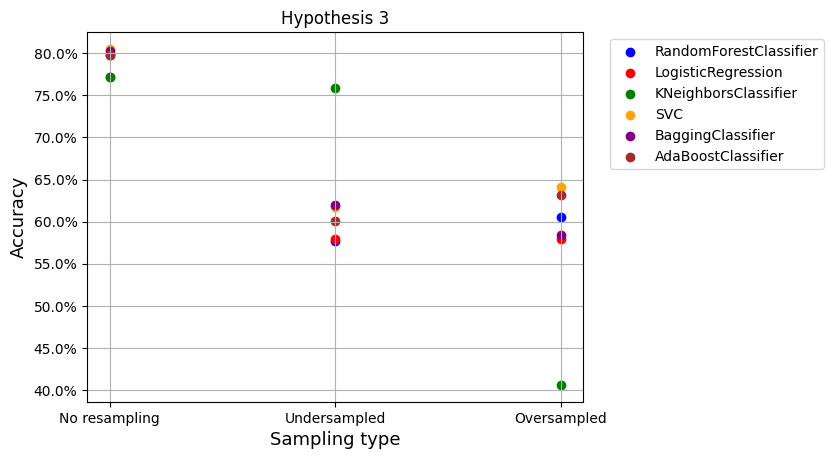

In [29]:
# Hypothesis 3
create_plot(hip3, "Hypothesis 3")

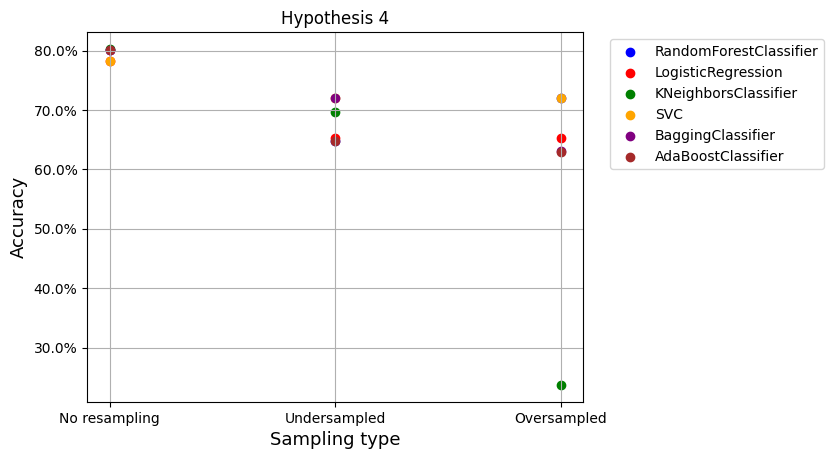

In [30]:
# Hypothesis 4
create_plot(hip4, "Hypothesis 4")